##### Import necessary packages

In [110]:
import sys
sys.path.append('../csv_data')

In [111]:
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute
from keras.layers import Merge, Input, concatenate, average, add
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses

#Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import time
from datetime import date
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

In [113]:
import _pickle as cPickle

from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')

###### Functions for loading data

In [114]:
def load_text_csv(filename = 'multimodel/Combined_News_DJIA.csv', date_split = date(2014,12,31)):
    '''
    Load news from csv, group them and split in train/test set due to @date_split
    '''
    df = pd.read_csv(filename)
    df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)
    
    train = df.loc[(pd.to_datetime(df["Date"]) <= date_split),['Label','Combined']]
    test = df.loc[(pd.to_datetime(df["Date"]) > date_split),['Label','Combined']]
    
    return train, test

In [115]:
'''Using news as a input!!'''
train, test = load_text_csv()
print(len(train), len(test))
print(type(test))
print(test[:5])

1611 378
<class 'pandas.core.frame.DataFrame'>
      Label                                           Combined
1611      1  [ 'Most cases of cancer are the result of shee...
1612      0  [ 'Moscow-&gt;Beijing high speed train will re...
1613      0  ['US oil falls below $50 a barrel'\n "Toyota g...
1614      1  ["'Shots fired' at French magazine HQ"\n '90% ...
1615      1  [ 'New Charlie Hebdo issue to come out next we...


In [116]:
def data2change(data):
    change = pd.DataFrame(data).pct_change()
    change = change.replace([np.inf, -np.inf], np.nan)
    change = change.fillna(0.).values.tolist()
    change = [c[0] for c in change]
    return change

In [117]:
def load_ts_csv(filename = 'multimodel/DJIA_table.csv', date_split = date(2014,12,31)):
    '''
    Load time series from csv, taking adjustment close prices;
    transforming them into percentage of price change;
    split in train/test set due to @date_split
    '''
    
    data_original = pd.read_csv(filename)[::-1]
    
    train2 = data_original.loc[(pd.to_datetime(data_original["Date"]) <= date_split)]
    test2 = data_original.loc[(pd.to_datetime(data_original["Date"]) > date_split)]
    
    open_train = train2.loc[:, 'Open']
    open_test = test2.loc[:, 'Open']
    
    high_train = train2.loc[:, 'High']
    high_test = test2.loc[:, 'High']
    
    low_train = train2.loc[:, 'Low']
    low_test = test2.loc[:, 'Low']
    
    close_train = train2.loc[:, 'Close']
    close_test = test2.loc[:, 'Close']
    
    volume_train = train2.loc[:, 'Volume']
    volume_test = test2.loc[:, 'Volume']
    
    open_train = data2change(open_train)
    open_test = data2change(open_test)
    
    high_train = data2change(high_train)
    high_test = data2change(high_test)
    
    low_train = data2change(low_train)
    low_test = data2change(low_test)
    
    close_test = data2change(close_test)
    close_train = data2change(close_train)
    
    volume_train = data2change(volume_train)
    volume_test = data2change(volume_test)
    
    train = np.column_stack((open_train, high_train, low_train, close_train, volume_train))
    test = np.column_stack((open_test, high_test, low_test, close_test, volume_test))
    
    print(train.shape)
    print(test.shape)
    
    return train, test

In [118]:
'''[open price, high price, low price, close price, volume]'''
data_chng_train, data_chng_test = load_ts_csv()
print(len(data_chng_train), len(data_chng_test))
print(data_chng_test[:5])

(1611, 5)
(378, 5)
1611 378
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [ -9.92831745e-05  -7.26827764e-03  -1.44022763e-02  -1.85801617e-02
    5.23010358e-01]
 [ -1.77944975e-02  -1.34810586e-02  -1.22202682e-02  -7.42842893e-03
   -1.23019972e-01]
 [ -7.39254243e-03   9.11737142e-04   6.51186144e-03   1.22543927e-02
   -1.06410131e-01]
 [  1.25003836e-02   1.81256767e-02   1.25003836e-02   1.83883108e-02
    2.62111392e-01]]


###### Processing Data

In [119]:
def transform_text_into_vectors(train_text, test_text, embedding_size = 100, model_path = 'word2vec10.model'):
    '''
        Transforms sentences into sequences of word2vec vectors
        Returns train, test set and trained word2vec model
    '''
    data_for_w2v = []
    for text in train_text + test_text:
        words = text.split(' ')
        data_for_w2v.append(words)

    model = Word2Vec(data_for_w2v, size=embedding_size, window=5, min_count=1, workers=4)
    model.save(model_path)
    model = Word2Vec.load(model_path)

    train_text_vectors = [[model[x] for x in sentence.split(' ')] for sentence in train_text]
    test_text_vectors = [[model[x] for x in sentence.split(' ')] for sentence in test_text]

    train_text_vectors = [np.mean(x, axis=0) for x in train_text_vectors]
    test_text_vectors = [np.mean(x, axis=0) for x in test_text_vectors]

    return train_text_vectors, test_text_vectors, model

In [120]:
train_text = cPickle.load(open('multimodel/train_text.p', 'rb'))[:]
test_text = cPickle.load(open('multimodel/test_text.p', 'rb'))[:]
print(len(train_text), len(test_text))
print(test_text[:1])

1611 378
['case cancer result sheer bad luck rather unhealthi lifestyl diet even inherit gene new research suggest random mutat occur dna cell divid respons two third adult cancer across wide rang tissu iran dismiss unit state effort fight islam state ploy advanc u polici region realiti unit state act elimin daesh even interest weaken daesh interest manag poll one 8 german would join anti muslim march uk royal famili princ andrew name us lawsuit underag sex alleg 40 asylum seeker refus leav bu arriv destin rural northern sweden demand taken back malm big citi pakistani boat blow self india navi chase four peopl board vessel near pakistani port citi karachi believ kill dramat episod arabian sea new year eve accord india defenc ministri sweden hit third mosqu arson attack week 940 car set alight french new year salari top ceo rose twice fast averag canadian sinc recess studi norway violat equal pay law judg say judg find consul employe unjustli paid 30 000 less male counterpart imam want

In [121]:
train_text_vectors, test_text_vectors, model = transform_text_into_vectors(train_text, test_text, 100)
print(len(train_text_vectors), len(test_text_vectors))
print(type(model))
print(test_text_vectors[:2])

1611 378
<class 'gensim.models.word2vec.Word2Vec'>
[array([  7.04339743e-02,   3.90487701e-01,  -5.20477891e-02,
        -3.22473109e-01,   6.54451773e-02,  -3.48789215e-01,
         3.16370666e-01,  -3.95053744e-01,  -7.10589170e-01,
         2.81793982e-01,  -8.34351331e-02,  -4.39769208e-01,
        -4.28961635e-01,   4.16660935e-01,   2.72161812e-01,
        -3.54525268e-01,  -2.05096290e-01,  -4.45461392e-01,
         3.99229497e-01,  -1.68372840e-01,   1.27289474e-01,
        -1.84600785e-01,  -4.23597127e-01,   2.07033977e-01,
        -1.77551717e-01,   5.36276877e-01,   3.06709737e-01,
        -6.80167526e-02,   9.50721186e-03,   1.25350937e-01,
        -1.38251364e-01,   2.89648592e-01,  -5.32856584e-02,
         3.15650910e-01,   1.41548701e-02,  -3.28086950e-02,
        -2.14281231e-02,   4.97224033e-02,  -2.95984864e-01,
         3.00398558e-01,  -2.59565383e-01,   2.43289217e-01,
        -2.00663671e-01,  -2.01147169e-01,   1.34392247e-01,
         2.11744174e-01,  -5.2557

In [122]:
def split_into_XY(data_chng_train, train_text_vectors, step, window, forecast):
    '''
        Splits textual and time series data into train or test dataset for hybrid model;
        objective y_i is percentage change of price movement for next day
    '''
    X_train, X_train_text, Y_train, Y_train2 = [], [], [], []
    for i in range(0, len(data_chng_train), step): 
        try:
            x_i = data_chng_train[i:i+window]
            y_i = np.std(data_chng_train[i:i+window+forecast][3])

            text_average = train_text_vectors[i:i+window]
            last_close = x_i[-1]
            y_i2 = None
            if data_chng_train[i+window+forecast][3] > 0.:
                y_i2 = 1.
            else:
                y_i2 = 0.

        except Exception as e:
            print('KEK', e)
            break

        X_train.append(x_i)
        X_train_text.append(text_average)
        Y_train.append(y_i)
        Y_train2.append(y_i2)

    X_train, X_train_text, Y_train, Y_train2 = np.array(X_train), np.array(X_train_text), np.array(Y_train), np.array(Y_train2)
    return X_train, X_train_text, Y_train, Y_train2

In [123]:
X_train, X_train_text, Y_train, Y_train2 = split_into_XY(data_chng_train, train_text_vectors, 1, 30, 1)
X_test, X_test_text, Y_test, Y_test2 = split_into_XY(data_chng_test, test_text_vectors, 1, 30, 1)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

KEK index 1611 is out of bounds for axis 0 with size 1611
KEK index 378 is out of bounds for axis 0 with size 378


In [124]:
main_input = Input(shape=(30, 5), name='ts_input')
text_input = Input(shape=(30, 100), name='text_input')

lstm1 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(main_input)
lstm1 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm1)
lstm1 = Flatten()(lstm1)

lstm2 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(text_input)
lstm2 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm2)
lstm2 = Flatten()(lstm2)

lstms = concatenate([lstm1, lstm2])

In [125]:
x1 = Dense(64)(lstms)
x1 = LeakyReLU()(x1)
x1 = Dense(1, activation = 'linear', name='regression')(x1)

x2 = Dense(64)(lstms)
x2 = LeakyReLU()(x2)
x2 = Dropout(0.9)(x2)
x2 = Dense(1, activation = 'sigmoid', name = 'class')(x2)

In [126]:
final_model = Model(inputs=[main_input, text_input], 
              outputs=[x1, x2])
opt = Nadam(lr=0.002, clipnorm = 0.5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="model.hdf5", verbose=1, save_best_only=True)
final_model.compile(optimizer=opt, loss={'regression': 'mse', 'class': 'binary_crossentropy'}, loss_weights=[1., 0.2])

In [127]:
for layer in final_model.layers:
    print(layer, layer.output_shape)

<keras.engine.topology.InputLayer object at 0x129d2a278> (None, 30, 5)
<keras.engine.topology.InputLayer object at 0x129d2a048> (None, 30, 100)
<keras.layers.recurrent.LSTM object at 0x129d2a470> (None, 30, 10)
<keras.layers.recurrent.LSTM object at 0x127c810f0> (None, 30, 10)
<keras.layers.recurrent.LSTM object at 0x129d2a160> (None, 30, 10)
<keras.layers.recurrent.LSTM object at 0x13897f080> (None, 30, 10)
<keras.layers.core.Flatten object at 0x1242047b8> (None, 300)
<keras.layers.core.Flatten object at 0x13889c2b0> (None, 300)
<keras.layers.merge.Concatenate object at 0x11d16e240> (None, 600)
<keras.layers.core.Dense object at 0x12d90f358> (None, 64)
<keras.layers.core.Dense object at 0x12d90f518> (None, 64)
<keras.layers.advanced_activations.LeakyReLU object at 0x12292a780> (None, 64)
<keras.layers.advanced_activations.LeakyReLU object at 0x12d90f898> (None, 64)
<keras.layers.core.Dropout object at 0x122946e80> (None, 64)
<keras.layers.core.Dense object at 0x125574208> (None, 1)
<k

Train on 1580 samples, validate on 347 samples
Epoch 1/100
1580/1580 [==============================] - 2s - loss: 1.0317 - regression_loss: 0.8490 - class_loss: 0.9138 - val_loss: 1.1224 - val_regression_loss: 0.9278 - val_class_loss: 0.9729
Epoch 2/100
1580/1580 [==============================] - 2s - loss: 0.6169 - regression_loss: 0.4469 - class_loss: 0.8497 - val_loss: 0.2572 - val_regression_loss: 0.1173 - val_class_loss: 0.6991
Epoch 3/100
1580/1580 [==============================] - 2s - loss: 0.4827 - regression_loss: 0.3354 - class_loss: 0.7363 - val_loss: 0.6066 - val_regression_loss: 0.4659 - val_class_loss: 0.7039
Epoch 4/100
1580/1580 [==============================] - 2s - loss: 0.4258 - regression_loss: 0.2783 - class_loss: 0.7374 - val_loss: 0.1885 - val_regression_loss: 0.0499 - val_class_loss: 0.6934
Epoch 5/100
1580/1580 [==============================] - 2s - loss: 0.3510 - regression_loss: 0.2060 - class_loss: 0.7246 - val_loss: 0.4550 - val_regression_loss: 0.315

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


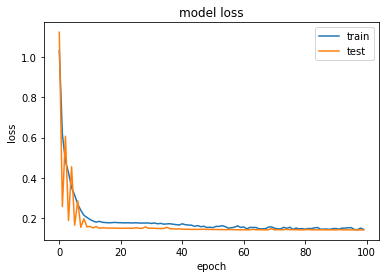

In [130]:
history = final_model.fit([X_train, X_train_text], [Y_train, Y_train2],
        nb_epoch = 100, 
        batch_size = 256, 
        verbose=1, 
        validation_data=([X_test, X_test_text], [Y_test, Y_test2]), 
        callbacks=[reduce_lr, checkpointer], shuffle=True)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


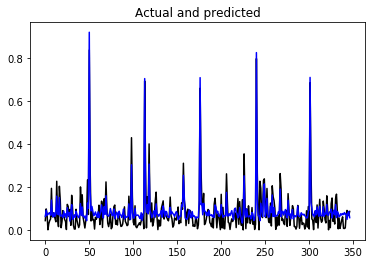

0.0188202172326
0.0729423060054
3.32715254069


In [131]:
final_model.load_weights("model.hdf5")
pred = final_model.predict([X_test, X_test_text])[0]

predicted = pred
original = Y_test

plt.title('Actual and predicted')
plt.legend(loc='best')
plt.plot(original, color='black', label = 'Original data')
plt.plot(pred, color='blue', label = 'Predicted data')
plt.show()


print(np.mean(np.square(predicted - original)))
print(np.mean(np.abs(predicted - original)))
print(np.mean(np.abs((original - predicted) / original)))